In [27]:
# Adding data from Google Could Storage to Colab File System
from google.colab import drive
drive.mount('/content/gdrive')

from google.colab import auth
auth.authenticate_user()

!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

!mkdir floodsDataset
!gcsfuse --implicit-dirs sen1floods11 floodsDataset

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0  36242      0 --:--:-- --:--:-- --:--:-- 36242
OK
66 packages can be upgraded. Run 'apt list --upgradable' to see them.
gcsfuse is already the newest version (0.41.1).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 66 not upgraded.
mkdir: cannot create directory ‘floodsDataset’: File exists
2022/05/13 06:25:34.986144 Start gcsfuse/0.41.1 (Go version go1.17.6) for app "" using mount point: /content/floodsDataset
2022/05/13 06:25:35.000741 Opening GCS connection...
2022/05/13 06:25:35.152420 Mounting file system

In [28]:
import tifffile as tfl
import numpy as np
import matplotlib.pyplot as plt
import glob as glob
import keras as k
from tensorflow import keras
import os


# Label Hand with S1 Hand Training data


In [29]:
!ls /content/floodsDataset/v1.1/data/perm_water/JRCPerm

 water_10_194_inhabited_167.78498987527377_-45.267540887186534.tif
 water_10_194_inhabited_169.08472865033218_-44.627307617033836.tif
 water_10_588_inhabited_-69.0890174214209_-16.10575129022326.tif
 water_10_589_inhabited_-69.26971803251075_-15.653179287904821.tif
 water_10_749_inhabited_85.60504168136961_48.73279303873935.tif
 water_10_749_inhabited_88.83010435467857_48.38121967528145.tif
 water_10_751_rural_85.61899420856585_28.867885787429604.tif
 water_10_754_inhabited_78.37066301877482_32.969638941553384.tif
 water_10_754_inhabited_78.51070554645935_33.89498267396236.tif
 water_10_764_inhabited_100.26516132826785_50.88880407088885.tif
 water_10_764_inhabited_100.61174941674798_51.43705946361214.tif
 water_10_769_inhabited_81.46284893979214_30.67961408634362.tif
 water_10_81_inhabited_25.74955169783489_-30.661884700555113.tif
 water_1_10_inhabited_18.058708237702003_-0.8408170128398617.tif
 water_1_10_inhabited_18.081953531493618_-0.9595316601857515.tif
 water_1_10_inhabited_18.12

In [30]:
!pip install tqdm
from tqdm.notebook import tqdm

In [31]:
dataset = glob.glob('/content/floodsDataset/v1.1/data/perm_water/JRCPerm/*.tif')
x =[]
y =[]
for i in tqdm(dataset):
  x.append(tfl.imread(i).shape[0])
  y.append(tfl.imread(i).shape[1])

  0%|          | 0/814 [00:00<?, ?it/s]

In [32]:
min(x),min(y)

(513, 510)

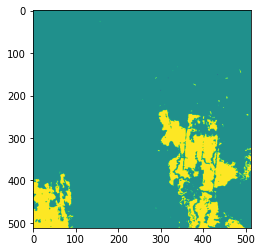

In [33]:
path = '/content/floodsDataset/v1.1/data/flood_events/HandLabeled/LabelHand/Mekong_342411_LabelHand.tif'

plt.imshow(tfl.imread(path))


## Validation Data Creation


total validation images: 89
total validation masks: 89
First 5 training images of validation data ['/content/floodsDataset/v1.1/data/flood_events/HandLabeled/S1Hand/Ghana_5079_S1Hand.tif', '/content/floodsDataset/v1.1/data/flood_events/HandLabeled/S1Hand/Ghana_895194_S1Hand.tif', '/content/floodsDataset/v1.1/data/flood_events/HandLabeled/S1Hand/Ghana_868803_S1Hand.tif', '/content/floodsDataset/v1.1/data/flood_events/HandLabeled/S1Hand/Ghana_142312_S1Hand.tif', '/content/floodsDataset/v1.1/data/flood_events/HandLabeled/S1Hand/Ghana_234935_S1Hand.tif']
First 5 masks images of validation data ['/content/floodsDataset/v1.1/data/flood_events/HandLabeled/LabelHand/Ghana_5079_LabelHand.tif', '/content/floodsDataset/v1.1/data/flood_events/HandLabeled/LabelHand/Ghana_895194_LabelHand.tif', '/content/floodsDataset/v1.1/data/flood_events/HandLabeled/LabelHand/Ghana_868803_LabelHand.tif', '/content/floodsDataset/v1.1/data/flood_events/HandLabeled/LabelHand/Ghana_142312_LabelHand.tif', '/content/fl

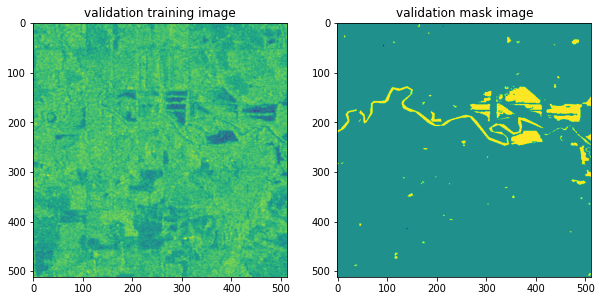

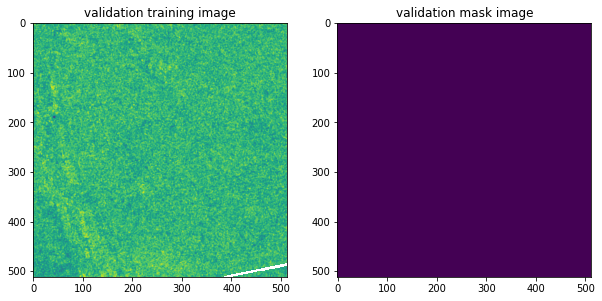

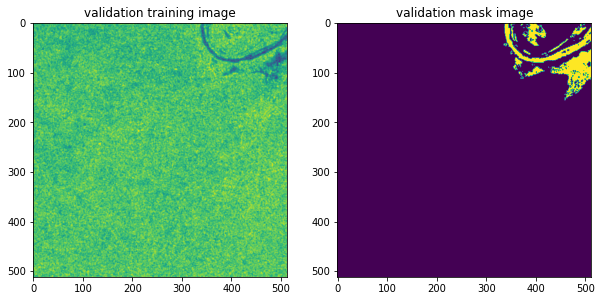

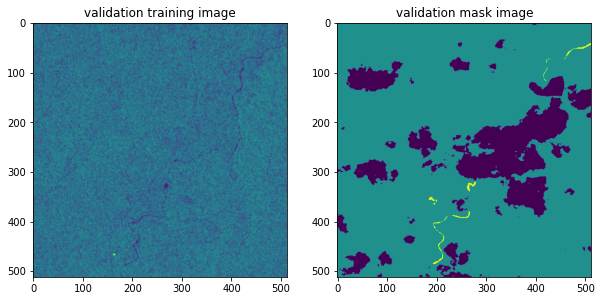

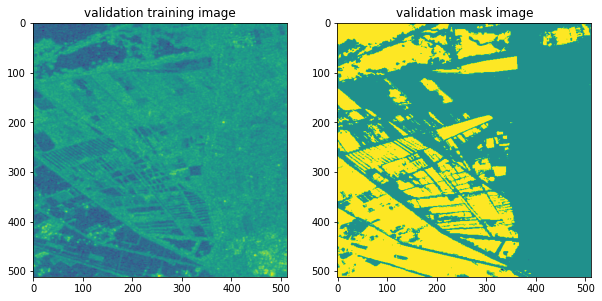

In [34]:
import pandas as pd
val_data = '/content/flood_valid_data.csv'
val_data = pd.read_csv(val_data)


val_image_list = val_data['Val Image'].tolist()
val_mask_list = val_data['Val Label'].tolist()

# make lists for validation image and validation mask directories

val_image_dir ='/content/floodsDataset/v1.1/data/flood_events/HandLabeled/S1Hand' 
val_mask_dir = '/content/floodsDataset/v1.1/data/flood_events/HandLabeled/LabelHand'


val_image_paths=[]
for i in val_image_list:
  val_image_paths.append(str(val_image_dir+'/'+i))

val_mask_paths=[]
for i in val_mask_list:
  val_mask_paths.append(str(val_mask_dir+'/'+i))



print(f'total validation images: {len(val_image_paths)}')
print(f'total validation masks: {len(val_mask_paths)}')
print(f'First 5 training images of validation data {val_image_paths[:5]}')
print(f'First 5 masks images of validation data {val_mask_paths[:5]}')



#Test to check if images are the same
for i in range (5) :
  n = np.random.randint(len(val_image_paths))
  fig,(ax1,ax2) = plt.subplots(1,2 ,figsize=(10,10))
  ax1.imshow(tfl.imread(val_image_paths[n])[0])
  ax1.set_title('validation training image')
  ax2.imshow(tfl.imread(val_mask_paths[n]))
  ax2.set_title('validation mask image')



# Training Data and testing data Creation 

total images: 814
total masks: 814
['/content/floodsDataset/v1.1/data/perm_water/S1Perm/sentinel_1_265_high_density_100.25397344372473_5.300448699311101.tif', '/content/floodsDataset/v1.1/data/perm_water/S1Perm/sentinel_12_789_low_density_25.076597544151998_35.328556908038905.tif', '/content/floodsDataset/v1.1/data/perm_water/S1Perm/sentinel_13_597_rural_-63.858906582126856_11.13171324712545.tif', '/content/floodsDataset/v1.1/data/perm_water/S1Perm/sentinel_1_289_high_density_107.20404428225288_-7.4654626564875155.tif', '/content/floodsDataset/v1.1/data/perm_water/S1Perm/sentinel_1_492_rural_-34.97631467942299_-6.473803173211687 (1).tif']
['/content/floodsDataset/v1.1/data/perm_water/JRCPerm/water_1_265_high_density_100.25397344372473_5.300448699311101.tif', '/content/floodsDataset/v1.1/data/perm_water/JRCPerm/water_12_789_low_density_25.076597544151998_35.328556908038905.tif', '/content/floodsDataset/v1.1/data/perm_water/JRCPerm/water_13_597_rural_-63.858906582126856_11.13171324712545

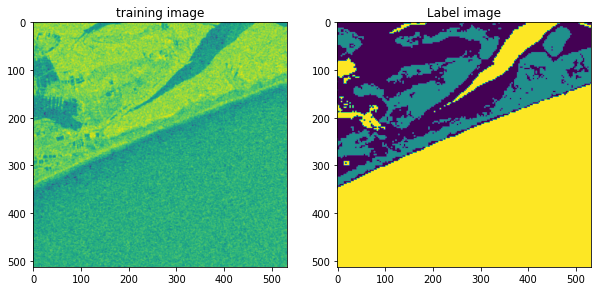

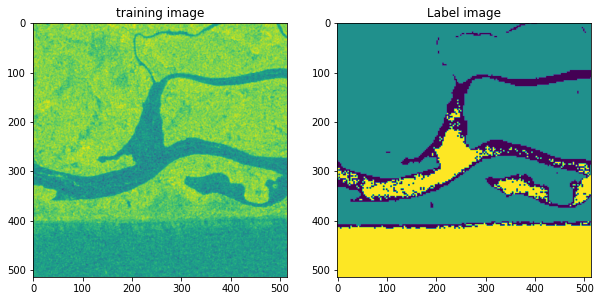

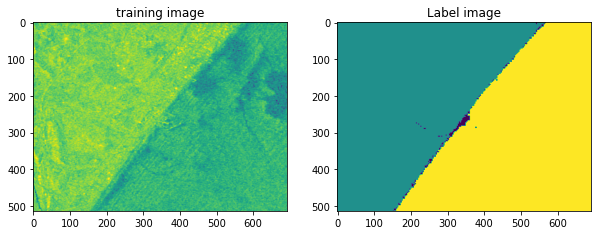

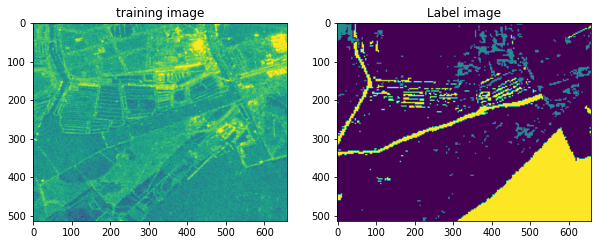

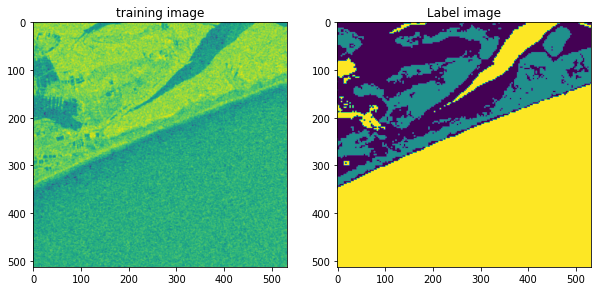

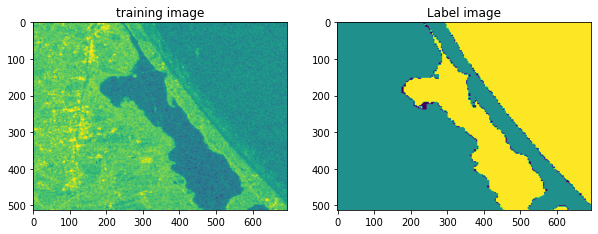

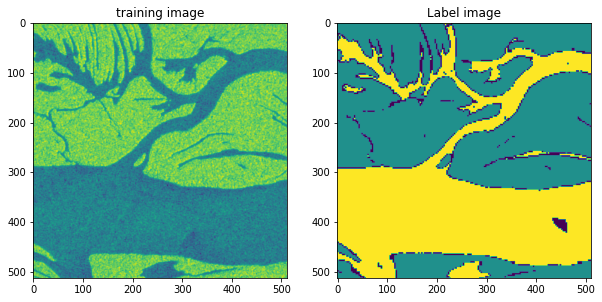

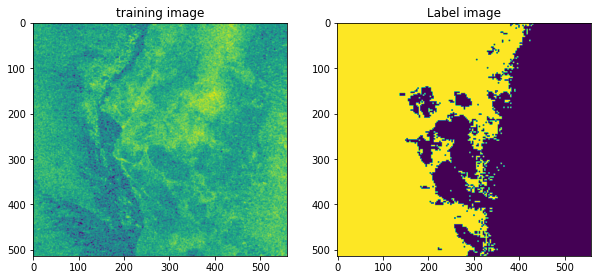

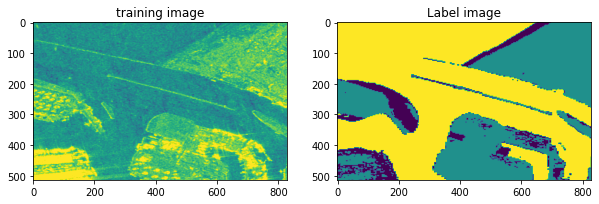

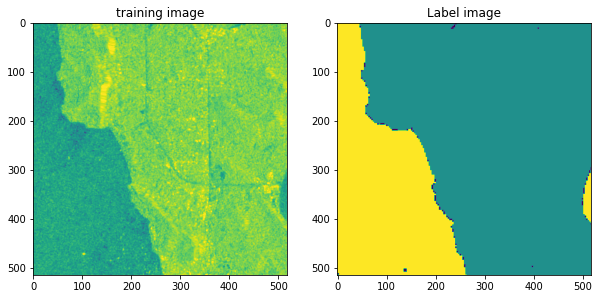

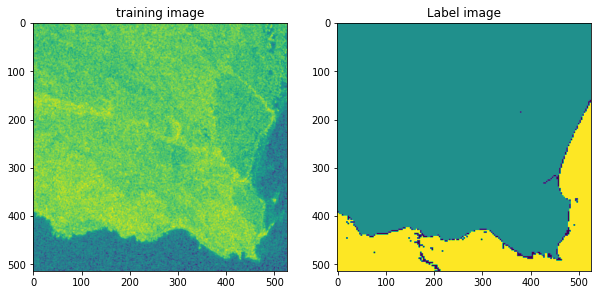

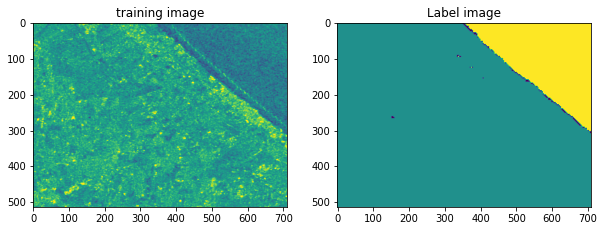

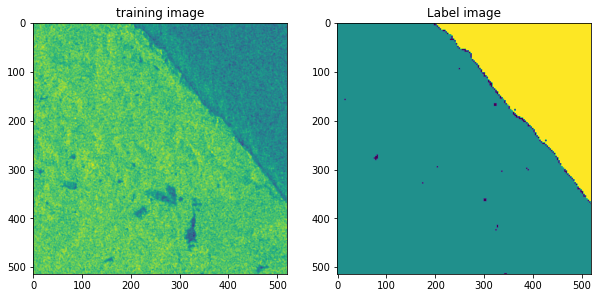

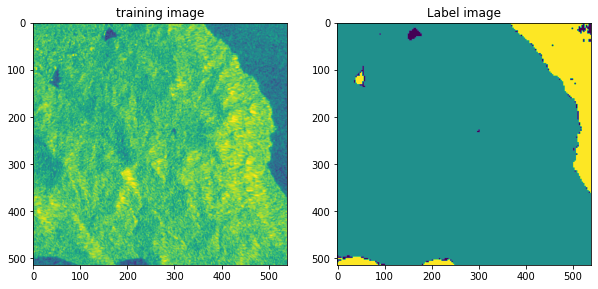

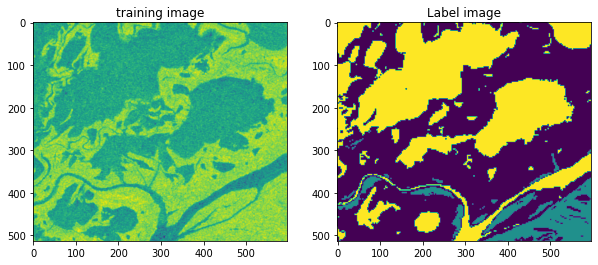

In [35]:
# make lists for image and mask directories
import glob
import random 

images_dir ='/content/floodsDataset/v1.1/data/perm_water/S1Perm'    # Change your code here for model training for both Weak Labeled and Hand Labeled datasets training data
masks_dir = '/content/floodsDataset/v1.1/data/perm_water/JRCPerm' # Change your code here for model training for both Weak Labeled and Hand Labeled datasets label data

image_paths = sorted(glob.glob(f'{images_dir}/*'))
mask_paths = sorted(glob.glob(f'{masks_dir}/*'))


# number of validation samples
test_samples = round(len(image_paths)*0.3)
# test_samples = round()

random.Random(1337).shuffle(image_paths)
random.Random(1337).shuffle(mask_paths)

# Split our img paths into a training and a validation set
train_image_paths = image_paths[:-test_samples]
train_mask_paths = mask_paths[:-test_samples]

test_image_paths = image_paths[-test_samples:]
test_mask_paths = mask_paths[-test_samples:]




print(f'total images: {len(image_paths)}')
print(f'total masks: {len(mask_paths)}')
print(image_paths[:5])
print(mask_paths[:5])


print(f'total test images: {len(test_image_paths)}')
print(f'total test masks: {len(test_mask_paths)}')
print(test_image_paths[:5])
print(test_mask_paths[:5])



# #Test to check if images are the same
for i in range (15) :
  n = np.random.randint(len(train_image_paths))
  fig,(ax1,ax2) = plt.subplots(1,2 ,figsize=(10,10))
  ax1.imshow(tfl.imread(train_image_paths[n])[0])
  ax1.set_title('training image')
  ax2.imshow(tfl.imread(train_mask_paths[n]))
  ax2.set_title('Label image')



In [36]:
path =glob.glob('/content/floodsDataset/v1.1/data/perm_water/S1Perm/*.tif')
n = np.random.randint(len(path))
img = tfl.imread(path[n])
print(img.shape)
img[np.where(np.isnan(img))] = 0
img = img[:,510:,510:]
img = np.moveaxis(img,0,2)
print(img.shape)


(2, 514, 615)
(4, 105, 2)


In [37]:
path =glob.glob('/content/floodsDataset/v1.1/data/perm_water/JRCPerm/*.tif')
n = np.random.randint(len(path))
mask = tfl.imread(path[n])
mask[np.where(np.isnan(mask))] = 0
mask = mask[:510,:510]
mask[mask == -1 ]= 0
mask= np.expand_dims(mask,-1)

print(mask.shape)

(510, 510, 1)


In [38]:

class FloodDataset1(keras.utils.Sequence):
    """
    Sequence class to load & vectorize batches of data.
    
    Iterate over the data (as Numpy arrays).
    
    Reference - https://keras.io/examples/vision/oxford_pets_image_segmentation/#prepare-sequence-class-to-load-amp-vectorize-batches-of-data
    """

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]

        # load images
        x = np.zeros((self.batch_size,) + self.img_size + (2,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = tfl.imread(path)
            img[np.where(np.isnan(img))] = 0
            img = img[:,:256,:256]
            img = np.moveaxis(img,0,2)

            
        

            x[j] = img

        # load masks
        y = np.zeros((self.batch_size,) + self.img_size+ (1,) , dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            mask = tfl.imread(path)
            mask[np.where(np.isnan(mask))] = 0
            mask[mask == -1 ]= 0
            mask = mask[:256,:256]
            mask= np.expand_dims(mask,-1)
            y[j] = mask  
            # print(np.unique(y[j]))
            
        return x, y

In [56]:
from dataset import FloodDataset
from keras.callbacks import ModelCheckpoint

img_size = (256, 256)
batch_size = 16

train_gen = FloodDataset1(batch_size,
                            img_size,
                            train_image_paths,
                            train_mask_paths)

test_gen = FloodDataset1(batch_size,
                            img_size,
                            test_image_paths,
                            test_mask_paths)



val_gen = FloodDataset1(batch_size,
                          img_size,
                          val_image_paths,
                          val_mask_paths)

x,y = train_gen[0]
print(f'Shape of training data {x.shape}, Shape of Label Data{y.shape}')

Shape of training data (16, 256, 256, 2), Shape of Label Data(16, 256, 256, 1)


In [57]:
print(len(train_gen),len(test_gen),len(val_gen))

35 15 5


In [58]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from loss import bce_dice_loss, dice_coef
from metrics import recall_m,precision_m,f1_m

activation_function = 'sigmoid'
num_classes = 1

from models import UNet
model = UNet(num_classes = num_classes,
         image_size = 256, 
         img_channels = 2,
         activation_fn = 'sigmoid')

# from models import DeepUNet
# model =  DeepUNet(num_classes=num_classes,
#              image_size=512,
#              img_channels=2,
#              activation_fn = 'sigmoid',
#              )
#// Cannot test DeepNet Model yet : Error (ResourceExhaustedError: Graph execution error:)

loss = bce_dice_loss # can use 'binary_crossentropy'
optimizer = Adam()

# compile model
model.compile(optimizer = optimizer, 
              loss = loss,
              metrics = [recall_m, 
                        precision_m, 
                        f1_m])

(16, 256, 256, 1) (16, 256, 256, 1)


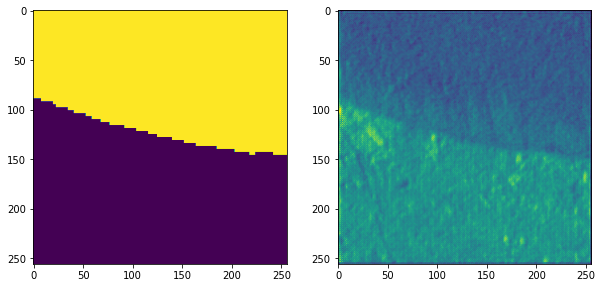

In [59]:
# Tesing with sample model to check input shape and output shape
x,y = train_gen[0]
x.shape,y.shape

test = model.predict(x)
print(test.shape,y.shape)

fig,(ax1,ax2) = plt.subplots(1,2 ,figsize=(10,10))
ax1.imshow(np.squeeze(y)[1])
ax2.imshow(np.squeeze(test)[1])


In [60]:
# Train the model, doing validation at the end of each epoch.
epochs = 20

# checkpoint = ModelCheckpoint("/content/Train_S1_hand_Label_S2.hdf5", monitor='f1_m', verbose=1,
#     save_best_only=True, mode='auto', period=1) 

history = model.fit(train_gen, 
          epochs=epochs, 
          validation_data=test_gen,
          verbose = 1)

Epoch 1/20
35/35 [==============================] - 125s 4s/step - loss: 0.5121 - recall_m: 0.8573 - precision_m: 0.6479 - f1_m: 0.7078 - val_loss: 0.3690 - val_recall_m: 0.7970 - val_precision_m: 0.7743 - val_f1_m: 0.7767
Epoch 2/20
35/35 [==============================] - 115s 3s/step - loss: 0.3600 - recall_m: 0.8661 - precision_m: 0.7894 - f1_m: 0.8189 - val_loss: 0.4411 - val_recall_m: 0.5867 - val_precision_m: 0.8333 - val_f1_m: 0.6759
Epoch 3/20
35/35 [==============================] - 114s 3s/step - loss: 0.3097 - recall_m: 0.8810 - precision_m: 0.8034 - f1_m: 0.8336 - val_loss: 0.3107 - val_recall_m: 0.8416 - val_precision_m: 0.8130 - val_f1_m: 0.8200
Epoch 4/20
35/35 [==============================] - 120s 3s/step - loss: 0.2911 - recall_m: 0.8958 - precision_m: 0.8161 - f1_m: 0.8491 - val_loss: 0.3301 - val_recall_m: 0.7766 - val_precision_m: 0.8350 - val_f1_m: 0.7969
Epoch 5/20
35/35 [==============================] - 113s 3s/step - loss: 0.2896 - recall_m: 0.8955 - precisi

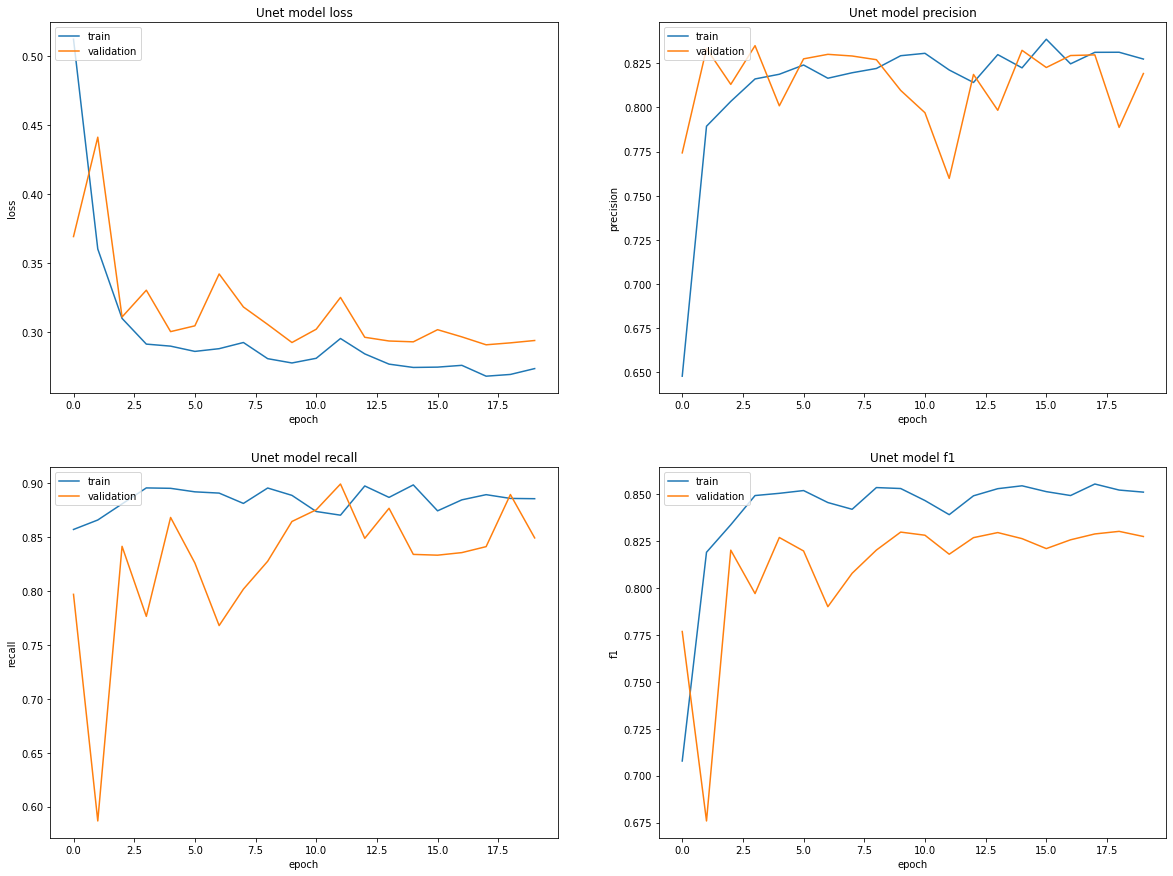

In [63]:
fig,((ax11,ax12),(ax13,ax14)) = plt.subplots(2,2,figsize=(20,15))
ax11.plot(history.history['loss'])
ax11.plot(history.history['val_loss'])
ax11.title.set_text('Unet model loss')
ax11.set_ylabel('loss')
ax11.set_xlabel('epoch')
ax11.legend(['train', 'validation'], loc='upper left')

ax12.plot(history.history['precision_m'])
ax12.plot(history.history['val_precision_m'])
ax12.set_title('Unet model precision')
ax12.set_ylabel('precision')
ax12.set_xlabel('epoch')
ax12.legend(['train', 'validation'], loc='upper left')

ax13.plot(history.history['recall_m'])
ax13.plot(history.history['val_recall_m'])
ax13.set_title('Unet model recall')
ax13.set_ylabel('recall')
ax13.set_xlabel('epoch')
ax13.legend(['train', 'validation'], loc='upper left')

ax14.plot(history.history['f1_m'])
ax14.plot(history.history['val_f1_m'])
ax14.set_title('Unet model f1')
ax14.set_ylabel('f1')
ax14.set_xlabel('epoch')
ax14.legend(['train', 'validation'], loc='upper left')
fig.savefig('7_Train_S1_Perm_Label_JRC_Label.png')

In [64]:
# Validation data

loss1,recall,precision,f1 = model.evaluate(test_gen,verbose=1)
print(f"Validation Metrics on Unet \nprecision :{precision*100} \nf1 score :{f1*100} \nrecall :{recall*100} \nLoss :{loss1}")

15/15 [==============================] - 38s 3s/step - loss: 0.2937 - recall_m: 0.8494 - precision_m: 0.8192 - f1_m: 0.8273
Validation Metrics on Unet 
precision :81.91810250282288 
f1 score :82.73088335990906 
recall :84.94269251823425 
Loss :0.2936791181564331


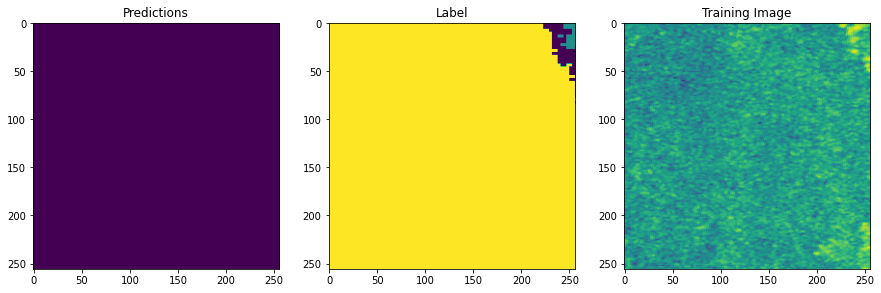

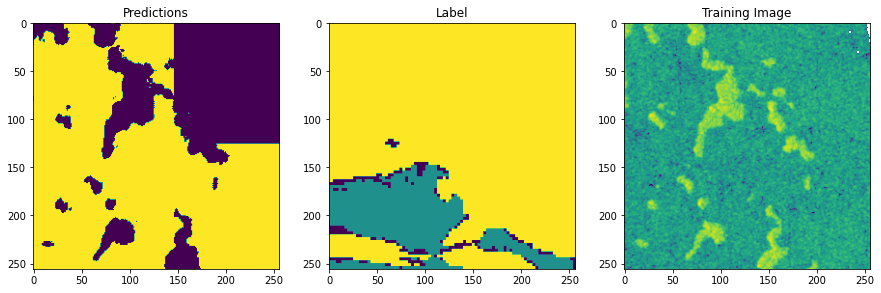

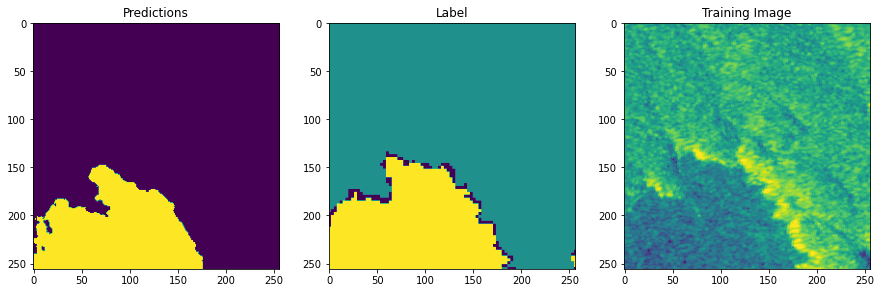

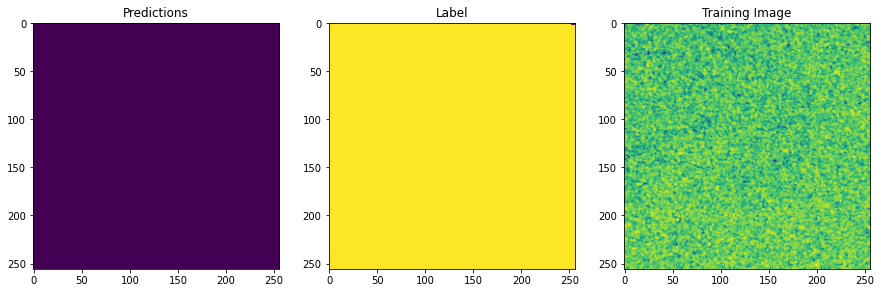

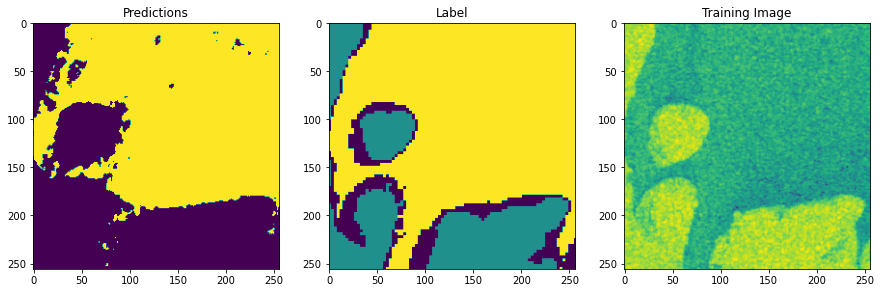

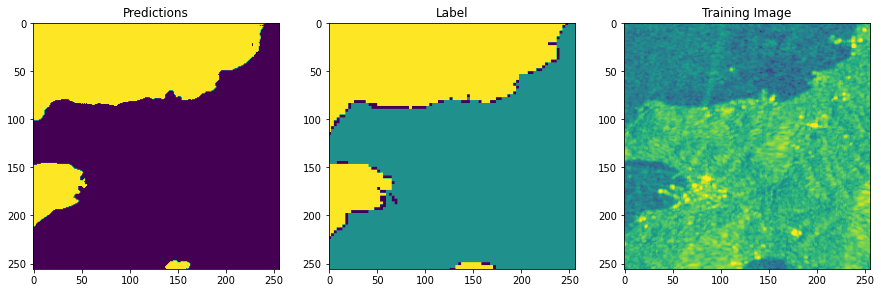

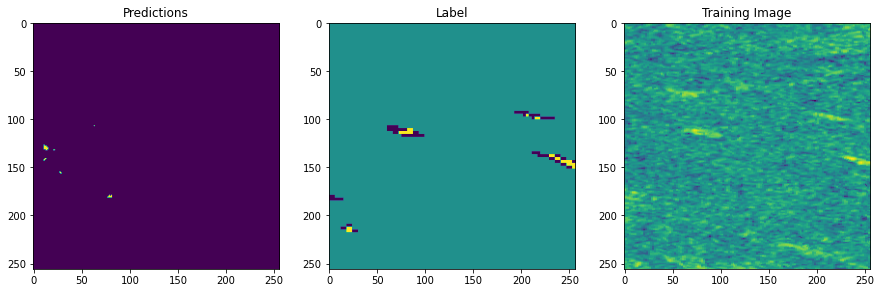

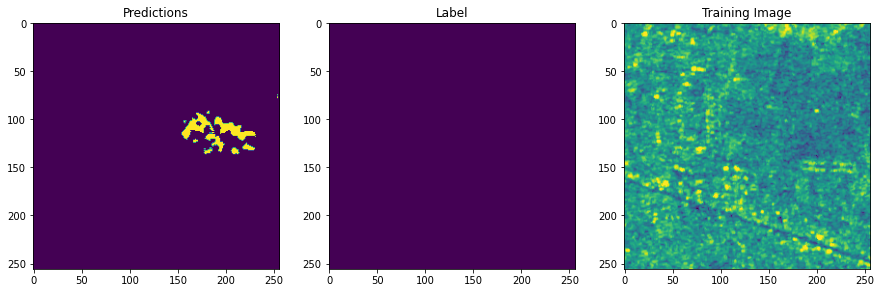

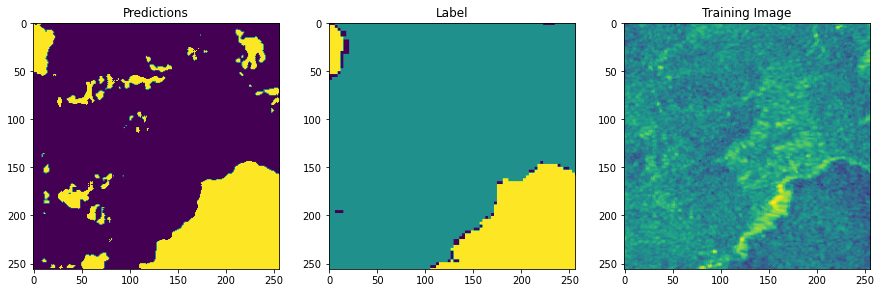

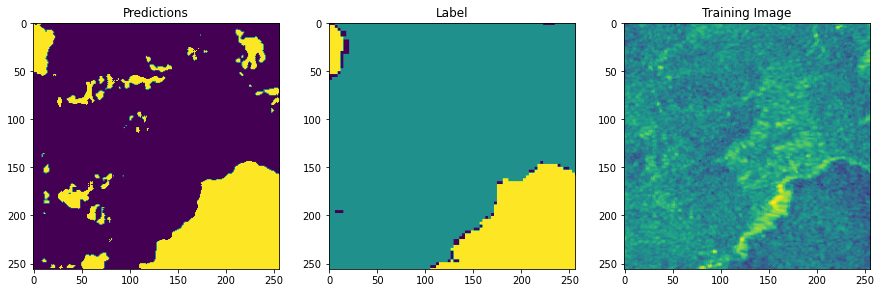

In [65]:
for i in range( 10):
  n = np.random.randint(len(test_image_paths))

  # print(f"Inferecne Image Path {image_paths[n]}")
  # print(f"Inference Mask Path {mask_paths[n]}")
  infer_image = test_image_paths[n]
  infer_label = test_mask_paths[n]

  
  # img = tfl.imread(path)
  # img[np.where(np.isnan(img))] = 0
  # img = img[:,:256,:256]
  # img = np.moveaxis(img,0,2)

  sample = np.moveaxis(tfl.imread(infer_image)[:,:256,:256],0,2)
  threshold = 0.5
  pred_img = np.expand_dims(sample, axis = 0)
  val_preds = model.predict(pred_img)
  val_preds = np.squeeze(val_preds)
  val_preds = val_preds > threshold

  fig,(ax1,ax2,ax3)= plt.subplots(1,3,figsize=(15,10))
  ax1.imshow(val_preds);
  ax1.set_title("Predictions")
  ax2.imshow(tfl.imread(infer_label)[:256,:256]);
  ax2.set_title("Label")
  ax3.imshow(tfl.imread(infer_image)[:,:256,:256][0]);
  ax3.set_title('Training Image')

  fig.savefig('Preds/Preds_'+str(i)+'.png')


In [66]:
 !zip -r '/content/Preds_7_Train_S1_Label_JRC_Hand.zip' '/content/Preds'

  adding: content/Preds/ (stored 0%)
  adding: content/Preds/Preds_4.png (deflated 3%)
  adding: content/Preds/Preds_5.png (deflated 4%)
  adding: content/Preds/Preds_2.png (deflated 4%)
  adding: content/Preds/Preds_3.png (deflated 4%)
  adding: content/Preds/Preds_7.png (deflated 4%)
  adding: content/Preds/Preds_1.png (deflated 3%)
  adding: content/Preds/Preds_8.png (deflated 3%)
  adding: content/Preds/Preds_9.png (deflated 3%)
  adding: content/Preds/Preds_0.png (deflated 4%)
  adding: content/Preds/Preds_6.png (deflated 4%)


In [50]:
model.save('/content/7_Train_S1_Perm_Label_JRC_perm.h5')